<a href="https://colab.research.google.com/github/Jahnavi-Jaolekar/NYC-Taxi-time-prediction/blob/main/NYC_taxi_trip_time_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Title : NYC taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City**


# **BUSINESS CONTEXT**
Task is to build a model that predicts the total ride duration of taxi trips in New York City. Primary dataset is the one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

The primary goal of this project is to build a fundamental machine learning model that can forecast the typical trip time and cost for a given pickup location, dropoff location, date, and time. In order to gain an advantage over competitors and give customers greater value, every company today must effectively use its data. Making critical business decisions now often involves using machine learning, and libraries like data prep and sklearn make it possible for anyone, regardless of coding proficiency or domain expertise, to create models. One of the most potent libraries for machine learning is called Scikit Learn.

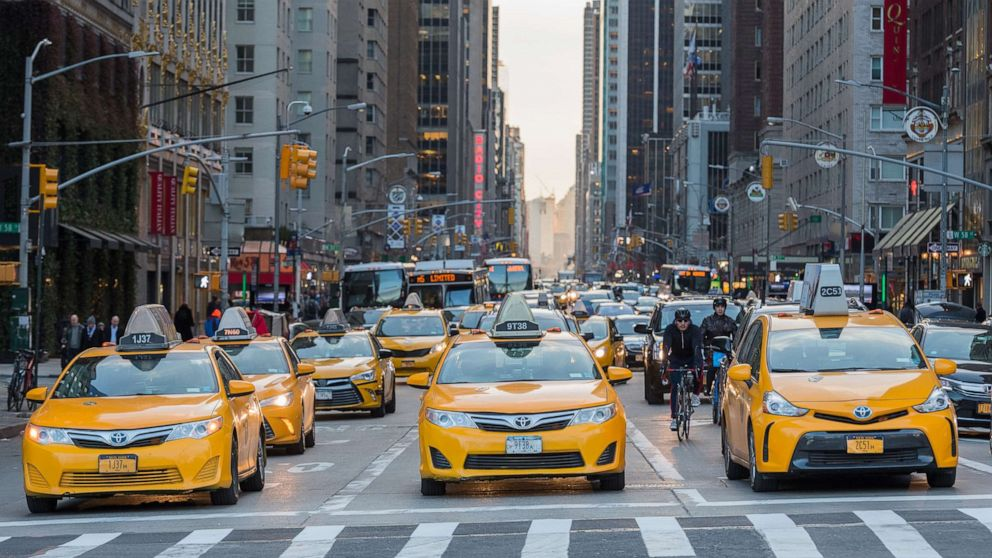

## **Understanding Dataset**
Importing necessary libraries and mounting drive

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# lets take a look at the data set
taxi_df=pd.read_csv('/content/drive/MyDrive/capstone project 2/Copy of NYC Taxi Data.csv')
taxi_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


# **Column Details**


*   **Id**: A unique identifier for each trip
*   **Vendor Id**: A unique identifier for each trip

*   **Pickup Datetime**: A unique identifier for each trip
*   **Dropoff Datetime**: A unique identifier for each trip

*   **Passenger Count**: The number of passengers in the vehicle (driver entered value)
*   **Pickup Longitude**: The number of passengers in the vehicle (driver entered value)

*   **Pickup Latitude**: The latitude where the meter was engaged
*   **Dropoff Longitude**: The longitude where the meter was disengaged

*   **Dropoff Latitude**: The latitude where the meter was disengaged

*   **Store and Fwd Flag**: This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip.
*   Trip Duration: Duration of time in seconds
















In [ ]:
rows=taxi_df.shape[0]
columns=taxi_df.shape[1]
print(f'Number of rows in dataset are {rows}')
print(f'Number of columns in dataset are {columns}')

Number of rows in dataset are 1458644
Number of columns in dataset are 11


In [ ]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [ ]:
taxi_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [ ]:
# Defining function to determine null values in dataset and datatype of the data
def brief():
  values=pd.DataFrame(index=taxi_df.columns)
  values['Null Count']= taxi_df.isnull().sum()
  values['Dtype']=taxi_df.dtypes
  return values 

In [ ]:
brief()

,Null Count,Dtype
id,0,object
vendor_id,0,int64
pickup_datetime,0,object
dropoff_datetime,0,object
passenger_count,0,int64
pickup_longitude,0,float64
pickup_latitude,0,float64
dropoff_longitude,0,float64
dropoff_latitude,0,float64
store_and_fwd_flag,0,object


### As we can see that we do not have any null values in the dataset, therefore we can move forward with the dataset...

In [ ]:
# Converting timestamp to datetime format
taxi_df['pickup_datetime']=pd.to_datetime(taxi_df['pickup_datetime'])
taxi_df['dropoff_datetime']=pd.to_datetime(taxi_df['dropoff_datetime'])
taxi_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### **Determining correlation between independent variables**

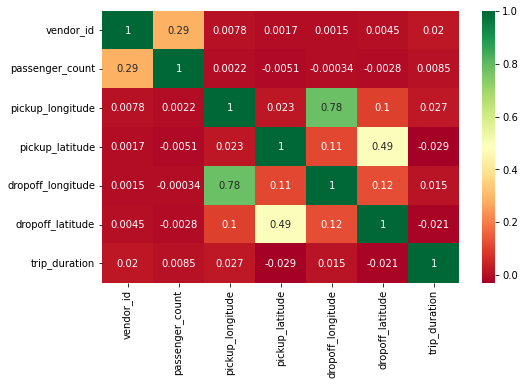

In [ ]:
plt.figure(figsize=(8,5))
sns.heatmap(taxi_df.corr(), annot=True, cmap='RdYlGn')

Above heatmap clearly shows that pickup longitude and dropoff longitude are highly correlated to each other.
(Multicollinearity: when independent variables are related to each other might beget false results during model prediction)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


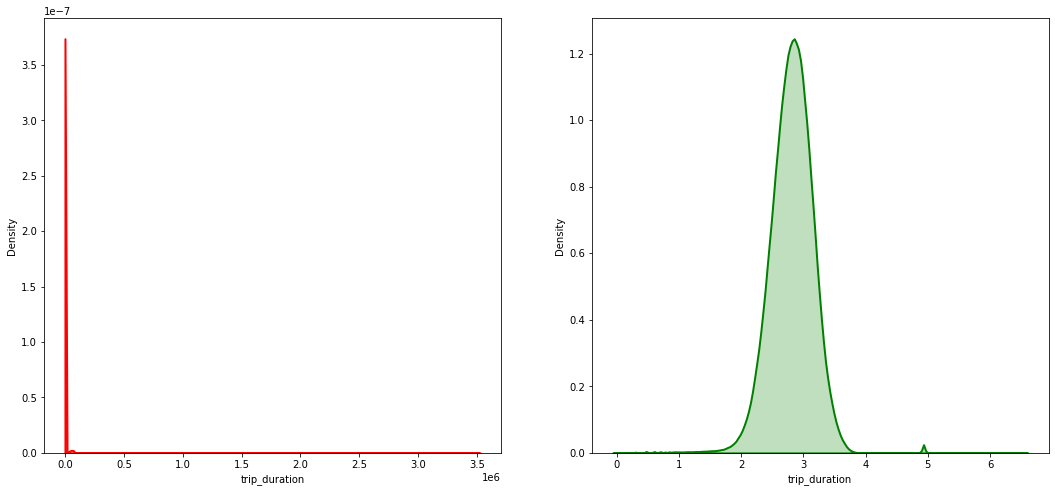

In [ ]:
fig,ax=plt.subplots(1,2, figsize=(18,8))
sns.distplot(taxi_df.trip_duration, hist= False, kde= True, kde_kws= {'shade':True, 'linewidth':2}, label= 'non_normal', color='red', ax=ax[0])
sns.distplot(np.log10(taxi_df['trip_duration']), hist= False, kde= True, kde_kws={'shade':True, 'linewidth':2}, label='normal', color='green',ax=ax[1])

Graph is positivley skewed so it needs to be regularized... we used log transformation to convert this into normal distribution